To validate some different RL algorithms the original FrozenLake-v0 environment is used. FrozenLake-v0 is considered solved when the agent obtains an average reward of at least $0.78$ over $100$ consecutive episodes.
## Algorithms
### Value Iteration

In [45]:
def value_iteration(env, gamma, max_iter, epsilon):
    U = np.zeros(env.nS)
    for i in range(max_iter):
        prev_U = np.copy(U)
        for s in range(env.nS):
            list_sum = np.zeros(env.nA)
            for a in range(env.nA):
                for p, s_prime, r, _ in env.P[s][a]:
                    list_sum[a] += p*(r + gamma*prev_U[s_prime])
            U[s] = max(list_sum)
        if (np.sum(np.fabs(prev_U - U)) <= epsilon):
            print("Converged at "+str(i))
            break
    return U

### Policy Iteration

In [46]:
def extract_policy(U, gamma):
    policy = np.zeros(env.nS)
    for s in range(env.nS):
        list_sum = np.zeros(env.nA)
        for a in range(env.nA):
            for p, s_prime, r, _ in env.P[s][a]:
                list_sum[a] += p*(r+gamma*U[s_prime])
        policy[s] = np.argmax(list_sum)
        #policy[s] = 50 + 20 * policy[s]
    return policy

def evaluate_policy(env, policy, gamma, epsilon):
    U = np.zeros(env.nS)
    while True:
        prev_U = np.copy(U)
        for s in range(env.nS):
            a = policy[s]
            U[s] = sum([p * (r + gamma * prev_U[s_]) for p, s_, r, _ in env.P[s][a]])
            #for p, s_prime, r, _ in env.P[s][a]:
                #U[s] += p*(r + gamma*prev_U[s_prime])
        if (np.sum(np.fabs(prev_U - U)) <= epsilon):
            break
    return U

def policy_iteration(env, gamma, max_iter, epsilon):
    policy = np.random.choice(env.nA, env.nS)
    for i in range(max_iter):
        U = evaluate_policy(env, policy, gamma, epsilon)
        new_policy = extract_policy(U, gamma)
        if (np.all(policy == new_policy)):
            print("Converged at " + str(i))
            break
        policy = new_policy
    return policy

### Q-Learning

In [68]:
def q_learning(env, alpha, gamma, nb_episodes, nb_steps, epsilon, epsilon_min, epsilon_decay):
    # Initialize the Q-table with zeros
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    rList = []
    for i in range(nb_episodes):
        rAll = 0
        s = env.reset()  # Initial observation
        for j in range(nb_steps):
            # The action associated to s is the one that provides the best Q-value with a proba 1-epsilon and is random with a proba epsilon
            if random.random() < 1 - epsilon:
                a = np.argmax(Q[s, :])
            else:
                a = np.random.randint(env.action_space.n)
            # We get our transition <s, a, r, s'>
            s_prime, r, d, _ = env.step(a)
            rAll += r
            # We update the Q-table with using new knowledge
            Q[s, a] = alpha * (r + gamma * np.max(Q[s_prime, :])) + (1 - alpha) * Q[s, a]
            s = s_prime
            if d == True:
                break
        if (epsilon > epsilon_min):
            epsilon *= epsilon_decay
        rList.append(rAll)
    return Q, rList

### Deep Q-Learning

In [63]:
def dql(env, gamma, nb_episodes, nb_steps, epsilon, epsilon_min, epsilon_decay):
    state_size = env.observation_space.n
    action_size = env.action_space.n
    
    inputs1 = tf.placeholder(shape=[1,state_size],dtype=tf.float32)
    W = tf.Variable(tf.random_uniform([state_size,action_size],0,0.01))
    Qout = tf.matmul(inputs1,W)
    predict = tf.argmax(Qout,1)

    nextQ = tf.placeholder(shape=[1,action_size],dtype=tf.float32)
    loss = tf.reduce_sum(tf.square(nextQ - Qout))
    trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
    updateModel = trainer.minimize(loss)

    init = tf.initialize_all_variables()
    
    #create lists to contain total rewards and steps per episode
    jList = []
    rList = []
    with tf.Session() as sess:
        sess.run(init)
        for i in range(nb_episodes):
            #Reset environment and get first new observation
            s = env.reset()
            rAll = 0
            d = False
            j = 0
            while j < nb_steps:
                j+=1
                #Choose an action by greedily (with e chance of random action) from the Q-network
                a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(state_size)[s:s+1]})
                if np.random.rand(1) < epsilon:
                    a[0] = env.action_space.sample()
                #Get new state and reward from environment
                s1,r,d,_ = env.step(a[0])
                #Obtain the Q' values by feeding the new state through our network
                Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(state_size)[s1:s1+1]})
                #Obtain maxQ' and set our target value for chosen action.
                maxQ1 = np.max(Q1)
                targetQ = allQ
                targetQ[0,a[0]] = r + gamma*maxQ1
                #Train our network using target and predicted Q values
                _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(state_size)[s:s+1],nextQ:targetQ})
                rAll += r
                s = s1
                if d == True:
                    break
            if (epsilon > epsilon_min):
                epsilon *= epsilon_decay
            jList.append(j)
            rList.append(rAll)
        Q_table = []
        for s in range(state_size):
            Q = sess.run(Qout, feed_dict={inputs1: np.identity(state_size)[s:s + 1]})
            Q_table.append(Q[0])
    return Q_table, rList


## Results

### Visualization

In [50]:
def visualize_policy_FL(policy):
    visu = ''
    for k in range(len(policy)):
        if k > 0 and k%4 == 0:
            visu += '\n'
        if k == 5 or k == 7 or k == 11 or k == 12 or k == 15:
            visu+='H'
        elif int(policy[k]) == 0:
            visu += 'L'
        elif int(policy[k]) == 1:
            visu += 'D'
        elif int(policy[k]) == 2:
            visu += 'R'
        elif int(policy[k]) == 3:
            visu += 'U'
    print(visu)
    
def run_episode(env, policy):
    """ Runs an episode and returns the total reward """
    obs = env.reset()
    total_reward = 0
    while True:
        obs, reward, done, _ = env.step(int(policy[obs]))
        total_reward += reward
        if done:
            break
    return total_reward

def average_n_episodes(env, policy, n_eval):
    """ Runs n episodes and returns the average of the n total rewards"""
    scores = [run_episode(env, policy) for _ in range(n_eval)]
    return np.mean(scores)

def q_to_policy_FL(Q):
    policy = []
    for l in Q:
        if l[0] == l[1] == l[2] == l[3] == 0.0:
            policy.append(0)
        else:
            for k in range(0, len(l)):
                if l[k] == max(l):
                    policy.append(k)
                    break
    return policy

def visualizing_epsilon_decay(nb_episodes, epsilon, epsilon_min, epsilon_decay):
    X = [k for k in range(nb_episodes)]
    Y = []
    for k in range(nb_episodes):
        
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
        Y.append(epsilon)
    plt.plot(X, Y, 'b')
    plt.title("Decaying epsilon over the number of episodes")
    plt.xlabel("Number of episodes")
    plt.ylabel("Epsilon")
    plt.grid()
    return plt.show()

### Parameters

In [77]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import random
import tensorflow as tf
%matplotlib inline

#Value and Policy Iteration
gamma = 0.99
env = gym.make('FrozenLake-v0')
env = env.unwrapped

#Q-Learning
alpha = 0.05
nb_episodes, nb_steps = 4000, 100
epsilon = 1
epsilon_min = 0.01
epsilon_decay = 0.9995

### Value Iteration

In [52]:
v = value_iteration(env, gamma, 100000, 1e-20)
policy = extract_policy(v, gamma)
visualize_policy_FL(policy)
print("Average reward over 100 episodes : "+str(average_n_episodes(env, policy, 100)))

Converged at 995
LUUU
LHLH
UDLH
HRDH
Average reward over 100 episodes : 0.82


### Policy Iteration

In [53]:
policy = policy_iteration(env, gamma, 100000, 1e-20)
visualize_policy_FL(policy)
print("Average reward over 100 episodes : "+str(average_n_episodes(env, policy, 100)))

Converged at 4
LUUU
LHLH
UDLH
HRDH
Average reward over 100 episodes : 0.81


### Q-Learning

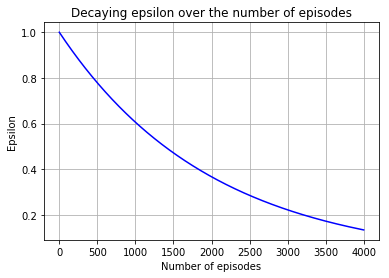

LULU
LHLH
UDLH
HRDH
Average reward over 100 episodes : 0.78


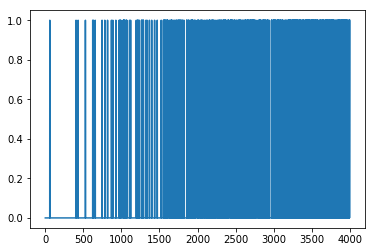

In [76]:
q_table, rList = q_learning(env, alpha, gamma, nb_episodes, nb_steps, epsilon, epsilon_min, epsilon_decay)
policy = q_to_policy_FL(q_table)
visualizing_epsilon_decay(nb_episodes, epsilon, epsilon_min, epsilon_decay)
visualize_policy_FL(policy)
print("Average reward over 100 episodes : "+str(average_n_episodes(env, policy, 100)))
plt.plot(rList)

### Deep-Q-Learning

here
LUUU
LHRH
UDLH
HRDH
Average reward over 100 episodes : 0.85


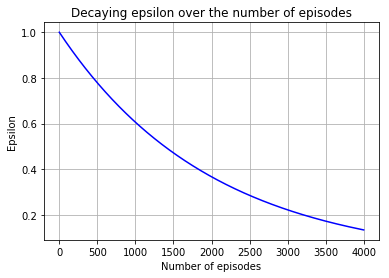

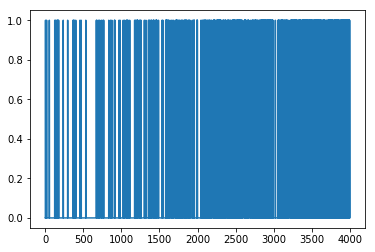

In [78]:
visualizing_epsilon_decay(nb_episodes, epsilon, epsilon_min, epsilon_decay)
q_table, rList = dql(env, gamma, nb_episodes, nb_steps, epsilon, epsilon_min, epsilon_decay)
policy = q_to_policy_FL(q_table)
visualize_policy_FL(policy)
print("Average reward over 100 episodes : "+str(average_n_episodes(env, policy, 100)))
plt.plot(rList)